In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import chi2_contingency
import itertools
sns.set_palette("Set2", 12)


# Context

**Целью** данной работы является анализ признаков и их взаимосвязей в предоставленном наборе данных о пассажирах Титаника, а также оценка признаков по возможности использования при построении предсказательных моделей.

Датасет представляет собой синтетические данные, основанные на реальном наборе данных о пассажирах Титаника.\
Источник данных:\
https://www.kaggle.com/c/tabular-playground-series-apr-2021/data?select=train.csv \
Загружаем данные и выводим информацию о датасете.


In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
99995,99995,1,2,"Bell, Adele",female,62.0,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.0,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.0,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.0,0,1,458654,30.92,NaN,S
99999,99999,0,3,"Enciso, Tyler",male,55.0,0,0,458074,13.96,NaN,S


In [5]:
print(f'Number of rows: {data.shape[1]}') 
print(f'Number of columns: {data.shape[0]}')

Number of rows: 12
Number of columns: 100000


В датасете содержится 100 000 наблюдений, охарактеризованных по 12 признакам:
* *PassengerId*: идентификатор пассажира. 
* *Survived*: выжил ли пассажир.
* *Pclass*: класс билета.         
* *Name*: имя пассажира.        
* *Sex*: пол пассажира.         
* *Age*: возраст пассажира.         
* *SibSp*: количество близких родственников (братьев/сестер, супругов) пассажира на борту.        
* *Parch*: количество близких родственников (детей, родителей) пассажира на борту.   
* *Ticket*: номер билета.      
* *Fare*: стоимость билета.         
* *Cabin*: номер каюты.
* *Embarked*: порт назначения.


# Data quality assessment

Проверяем данные на наличие дублирующихся наблюдений.


In [6]:
print(f'Number of duplicated rows: {data.duplicated().sum()}')

Number of duplicated rows: 0


Все строки предаставленны уникальными записями.\
Изучаем данные на наличие уникальных значений, устанавливаем количество пропущенных значений.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [8]:
for x in data.columns:
    print(f'{x}: unique values: {len(data[x].unique())}, NA values: {pd.isna(data[x]).sum()}' )


PassengerId: unique values: 100000, NA values: 0
Survived: unique values: 2, NA values: 0
Pclass: unique values: 3, NA values: 0
Name: unique values: 92144, NA values: 0
Sex: unique values: 2, NA values: 0
Age: unique values: 174, NA values: 3292
SibSp: unique values: 7, NA values: 0
Parch: unique values: 8, NA values: 0
Ticket: unique values: 75332, NA values: 4623
Fare: unique values: 15936, NA values: 134
Cabin: unique values: 26993, NA values: 67866
Embarked: unique values: 4, NA values: 250


В датасете содержится две количественные переменные (Fare, Age) и 10 качественных переменных.\
При первоначальной оценке, можно отметить, что признаки *PassengerId* и *Name* не представляют ценности для анализа данных. \
Passenger является уникальным идентификатором, количество уникальных значений соответствует количеству записей. Совпадает с индексом датасета.\
Количество уникальных значений Name также близко к количеству записей. Маловероятно, что будет найдена связь между именем и выживанием.

Для признков *Ticket* и *Cabin* количество уникальных значений также слишком высоко для использования их в анализе. \
Однако, возможно, удастся вычленить полезную информацию из данных признаков.

Наиболее перспективными для понимания зависимостей и связей выглядят признаки *Survived*, *Pclass*, *Sex*, *Age*, *SibSp*,
       *Parch*, *Fare*, *Embarked*. Так как для качественных признаков количество уникальных значений небольшое (2-8).

Для ряда признаков выявлены отсутствующие значения. При использовании данных для построения моделей эти значения необходимо будет удалить либо заменить каким-либо образом.
Для признака *Cabin* отсутствуют значения для 67,9% наблюдений, поэтому использовать данный признак нецелесообразно. \
Также отсутствуют значения для ~3-5% наблюдений по признакам *Age* и *Ticket*.\
Рассмотрим каждый из представляющих интерес для дальнейшего анализа признак более подробно.


У признака *Cabin* 67866 уникальных значений. Каждое значение начинается с буквы, далее следует набор из цифр. Извлечем первую букву 
из каждого значения признака и создадим новый признак *Cabin_class*

In [9]:
data.loc[:, 'Cabin_class'] = data.loc[:, 'Cabin'].apply(lambda x: str(x)[0])
data.loc[data['Cabin_class']=='n', 'Cabin_class'] = np.nan

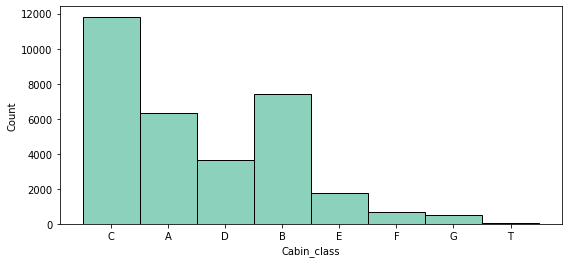

In [10]:
plt.figure(figsize=(9,4))
sns.histplot(data.Cabin_class.dropna());



<!-- statstr
Aggregate statistic to compute in each bin.

count: show the number of observations in each bin

frequency: show the number of observations divided by the bin width

probability: or proportion: normalize such that bar heights sum to 1

percent: normalize such that bar heights sum to 100

density: normalize such that the total area of the histogram equals 1 -->

In [11]:
data.Cabin_class.value_counts()

C    11825
B     7439
A     6307
D     3637
E     1749
F      663
G      482
T       32
Name: Cabin_class, dtype: int64

В результате данного преобразования количество значений у данного признака сократилось до 8. Однако количественное соотношение различных категорий признака неравномерно. Наиболее распространено значение С (11825 наблюдений). Реже всего встречается значение Т (32 наблюдения).

Количество уникальных значений признака Ticket составляет 75332, что также делает его непригодным для анализа и построения предсказательных моделей. Номер билет может состоять только из цифр, либо из букв и цифр. Создадим отдельную категорию digit для всех билетов, состоящих только из цифр. Для билетов, номера которых содержат буквы, извлечем буквенные обозначения, а также удалим несмысловые, вероятно, символы (. и /) для уменьшения числа категорий.
Сохраним данные в отдельную переменную Ticket_class.

In [12]:
data.loc[:, 'Ticket_class'] = data.loc[:, 'Ticket'].apply(lambda x: str(x).split()[0])
data.loc[data['Ticket_class'].apply(lambda x: x.isdigit()), 'Ticket_class'] = 'digit'
data.loc[:, 'Ticket_class'] = data['Ticket_class'].apply(lambda x: x.replace('/', '').replace('.', ''))
data.loc[data['Ticket_class']=='nan', 'Ticket_class'] = np.nan

In [13]:
print(f'Number of categories: {data.Ticket_class.unique().shape[0]}\n') 
print(f'Top-5 most frequent categories:\n{data.Ticket_class.value_counts().head()}')

Number of categories: 37

Top-5 most frequent categories:
digit    70722
PC        6375
A         3750
CA        2448
A5        1804
Name: Ticket_class, dtype: int64


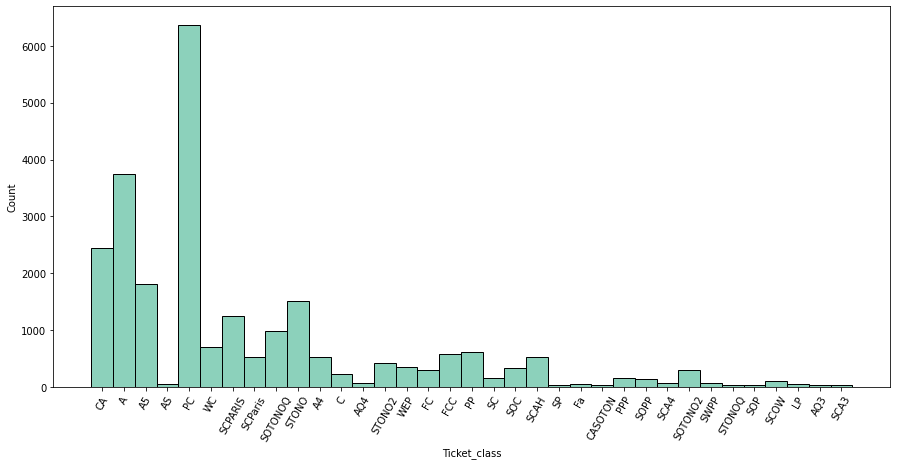

In [14]:
plt.figure(figsize=(15,7))
plt.xticks(rotation=60)
sns.histplot(data.loc[data.Ticket_class!='digit', 'Ticket_class'].dropna());

В результате, количество категорий сократилось до 37. При этом, 74,2% пассажиров имели билеты, состоящие из цифр (категория digit). Среди других категорий наибольшее число наблюдений у категории PC (6375), наименьшее - у категории AQ3 (30).

Рассмотрим признаки с небольшим количеством классов (категорий): Survived, Pclass, Sex, Embarked.

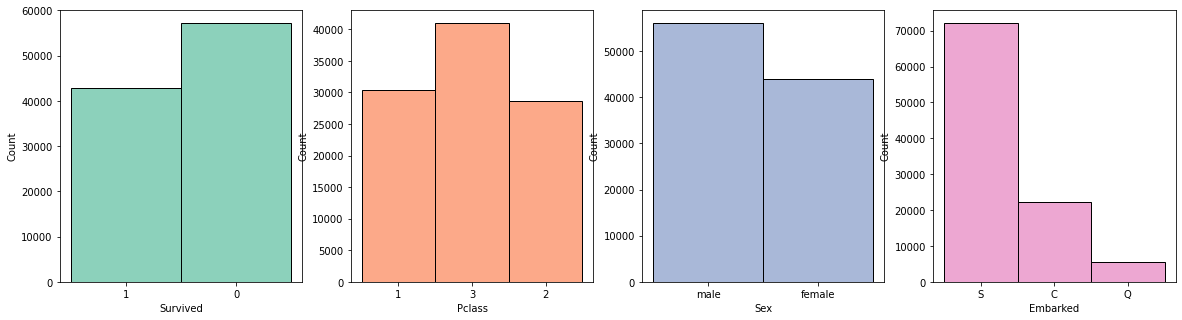

In [15]:
plt.figure(figsize=(20, 5))
cols = ['Survived', 'Pclass', 'Sex', 'Embarked']
palette = itertools.cycle(sns.color_palette("Set2"))

for i, column in enumerate(cols, 1):
    c = next(palette)
    plt.subplot(1,4,i)
    sns.histplot(data[column].dropna().apply(str), color=c)

Наблюдения по признакам Survived, Pclass, Sex распределены между категориями относительно равномерно. Что делает их достоверным и удобным источником для проведения анализа и построения моделей.\
Целевой признак - Survived, содержит классы выживший/не выживший в соотношении 0.43 к 0.57.\
По признаку Embarked наблюдается дисбаланс классов: 72,3% пассажиров плыли в пункт назначения S и только 5.43% - в пункт Q.

In [16]:
data.Embarked.value_counts(normalize=True)

S    0.723198
C    0.222426
Q    0.054376
Name: Embarked, dtype: float64

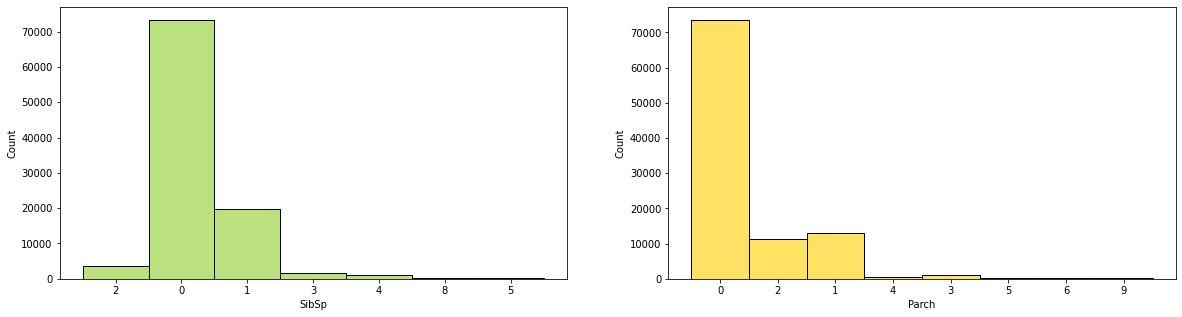

In [17]:
plt.figure(figsize=(20, 5))

for i, column in enumerate(['SibSp', 'Parch'], 1):
    c = next(palette)
    plt.subplot(1,2,i)
    sns.histplot(data[column].dropna().apply(str), color=c)

По признакам SibSp, Parch наблюдаются скошенные распределения. Более 73% пассажиров не имели родственников на борту.
Для снижения дисбаланса классов, создадим переменную Relatives с двумя категориями: 1 - если на борту были родственники (значения признаков Parch либо SibSp больше нуля),
0 - если на борту не было родственников.

In [18]:
data.loc[:, 'Relatives'] = np.where((data.Parch>0) | (data.SibSp>0), 1, 0)
data.Relatives.value_counts(normalize=True)

0    0.61853
1    0.38147
Name: Relatives, dtype: float64

Рассмотрим количественные переменные Fare и Age

In [19]:
data[['Fare', 'Age']].describe()

,Fare,Age
count,99866.00000,96708.000000
mean,43.92933,38.355472
std,69.58882,18.313556
min,0.68000,0.080000
25%,10.04000,25.000000
50%,24.46000,39.000000
75%,33.50000,53.000000
max,744.66000,87.000000


Наблюдается отклонение от нормального распределения и значительный разброс значений.

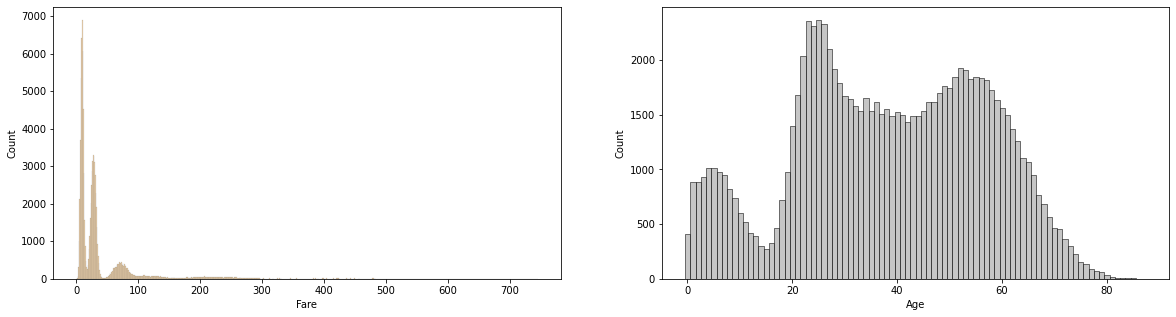

In [20]:
plt.figure(figsize=(20, 5))

for i, column in enumerate(['Fare', 'Age'], 1):
    c = next(palette)
    plt.subplot(1,2,i)
    sns.histplot(data[column], discrete=True, color=c)

Распределения частот признака Fare смещено вправо, с двумя пиками. Средняя составляет 43.93, при этом медиана равна 24.46, а мода - 9.56, то есть большая часть значений находится вблизи 10. Вероятно, данный признак связан с классом билета. \
Распределение для признака Age неравномерное. Большая часть пассажиров была в возрасте 20-60 лет, со средней в 38 лет и медианой в 39. Максимальное значение - 87 лет.
Так как возраст можно представить как категориальную переменную, создадим на основе признака Age новый признак Age_cat, где сгруппируем пассажиров в категории по 10 лет, например 0-10 лет, 51-60 лет и тд. Также может быть использована разбивка на группы "дети", "подростки" и тд.

In [21]:
bins = [x for x in range(0, 90, 10)]
transformer = FunctionTransformer(pd.cut, kw_args={'bins': bins, 'labels': bins[1:], 'retbins': False})
X = np.array([0.2, 2, 15, 25, 97])
transformer.fit_transform(X)
data.loc[:, 'Age_cat'] = transformer.fit_transform(data['Age'])

# Data exploration

Целевой переменной данного датасета является переменная Survived. Поэтому необходимо установить взаимосвязь между ней и другими переменными.\
Первоначально изучим связь данной переменной с категориальными признаками.

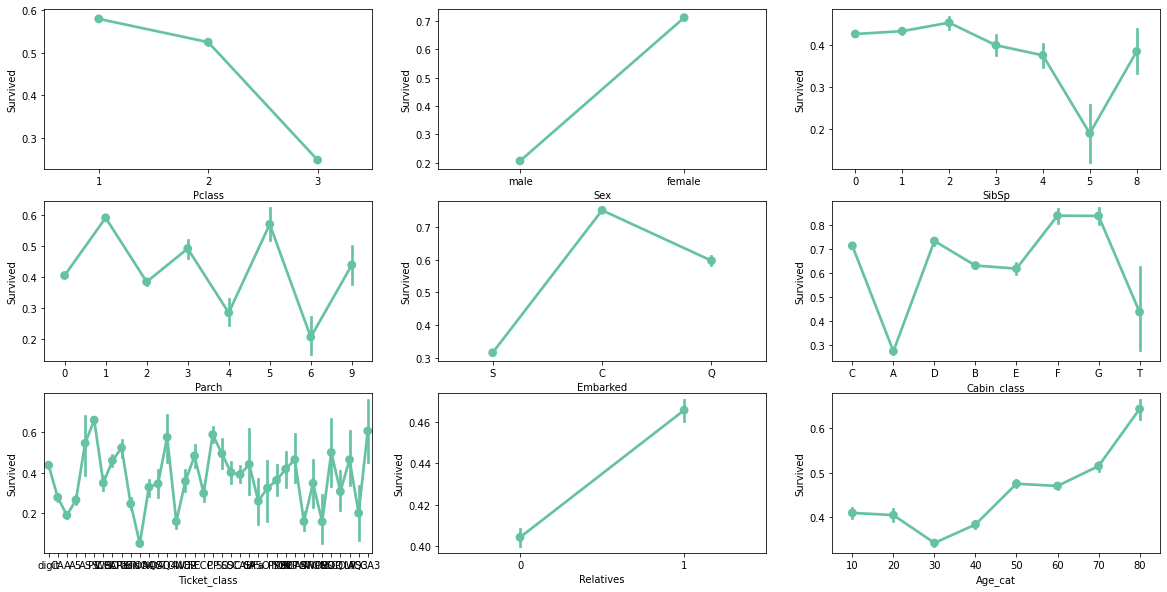

In [22]:
plt.figure(figsize=(20, 10))
cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin_class', 'Ticket_class', 'Relatives', 'Age_cat']

for i, column in enumerate(cols, 1):
    plt.subplot(3,3,i)
    sns.pointplot(x=data[column], y=data['Survived'])

Заметно наличие связи между признаками и целевой переменной. Наиболее сильная связь обнаруживается для признаков  Pclass, Sex, Embarked, Relatives. 
Рассчитаем параметры взаимосвязи между категориальными признаками с помощью критерия хи-квадрата и проанализируем достоверность полученных результатов.

In [23]:
cat_cols = ['Survived', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked', 'Cabin_class',
       'Ticket_class', 'Age_cat']
factors_paired = [(i,j) for i in cat_cols for j in cat_cols] 

chi2_tab, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(data[f[0]], data[f[1]]))   
        chi2_tab.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2_tab.append(0)
        p_values.append(0)
        
chi2_tab = np.array(chi2_tab).reshape(len(cat_cols),len(cat_cols)) # shape it as a matrix
chi2_tab = pd.DataFrame(chi2_tab, index=cat_cols, columns=cat_cols) # then a df for convenience

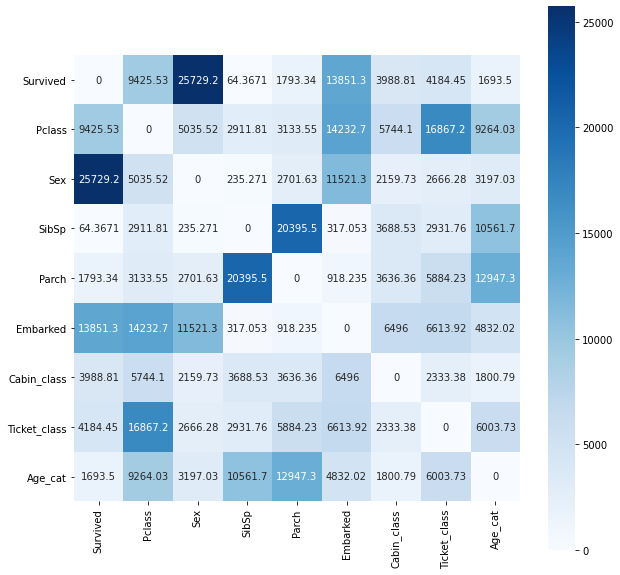

In [24]:
plt.figure(figsize = (10, 10));
sns.heatmap(chi2_tab, cbar=True, square=True, annot=True,  cmap=plt.cm.Blues, fmt='g');


In [25]:
print(f'Number of p-values greater than 0.01: {(np.array(p_values)>0.01).sum()}') 

Number of p-values greater than 0.01: 0


Значения p-уровня значимости для всех сравниваемых признаков меньше 0.01. Следовательно с 99% вероятностью можно утверждать, что между всеми изученными признаками имеется достоверная связь.\
Наибольшие значения критерия хи-квадрата для целевого признака получены в комбинации с признаками Sex, Pclass, Embarked. Проанализируем взаимоотношения этих признаков.

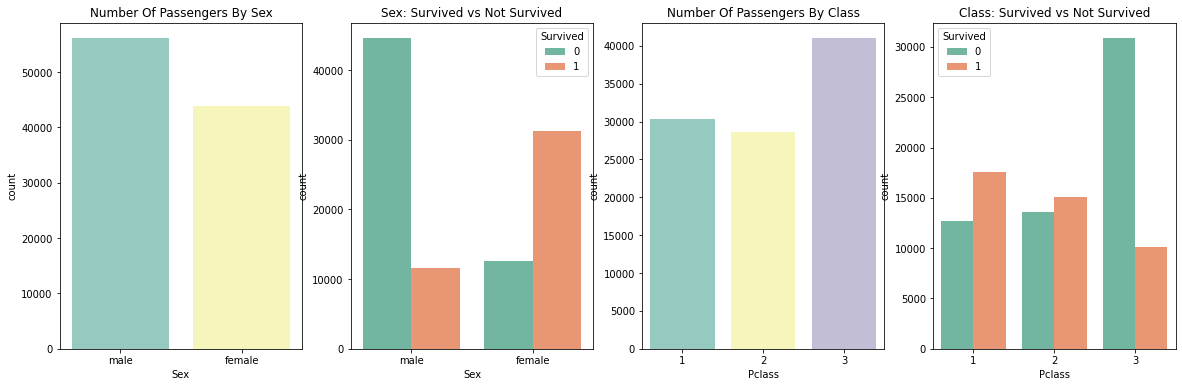

In [26]:
f,ax=plt.subplots(1,4,figsize=(20, 6))
sns.countplot(x="Sex", data=data ,ax=ax[0], palette="Set3")
ax[0].set_title('Number Of Passengers By Sex')

sns.countplot(x='Sex',hue='Survived',data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Not Survived')

sns.countplot(x="Pclass", data=data ,ax=ax[2], palette="Set3")
ax[2].set_title('Number Of Passengers By Class')

sns.countplot(x='Pclass',hue='Survived',data=data, ax=ax[3])
ax[3].set_title('Class: Survived vs Not Survived')
plt.show()

Несмотря на то, что количество пассажиров мужского пола превышает количество пассажиров женского пола (56.11% и 43.89%, соответственно), процент выживших женщин составляет 71.15%, в то время как среди мужчин выжили только 20.58%.\
В свою очередь, по признаку P Class наибольшее число пассажиров принадлежали к третьему классу (41.0%), однако количество выживших среди них составило только 24.73%, в то время как процент выживших 1 и 2 класса составил 57.98% и 52.50%, соответственно.\
Проанализируем влияние комбинации категорий признаков Sex и Pclass на вероятность выживания.

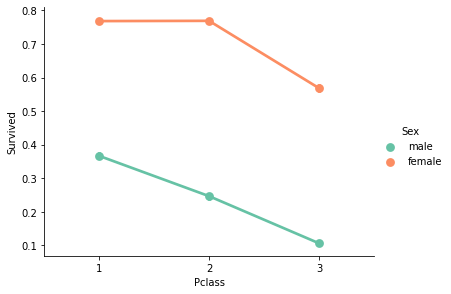

In [27]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="point", data=data, height=4, aspect=1.3);

Во всех трех классах количество выживших женщин значительно превышает количество выживших мужчин. Однако для третьего класса доля выживших женщин составила 57%, в то время как для первого и второго класса - около 80%. Процент выживших мужчин линейно коррелирует с классом, наибольшее число выживших среди мужчин в первом классе - 36.67%, в то время как для третьего класса число выживших составило 10.62%.


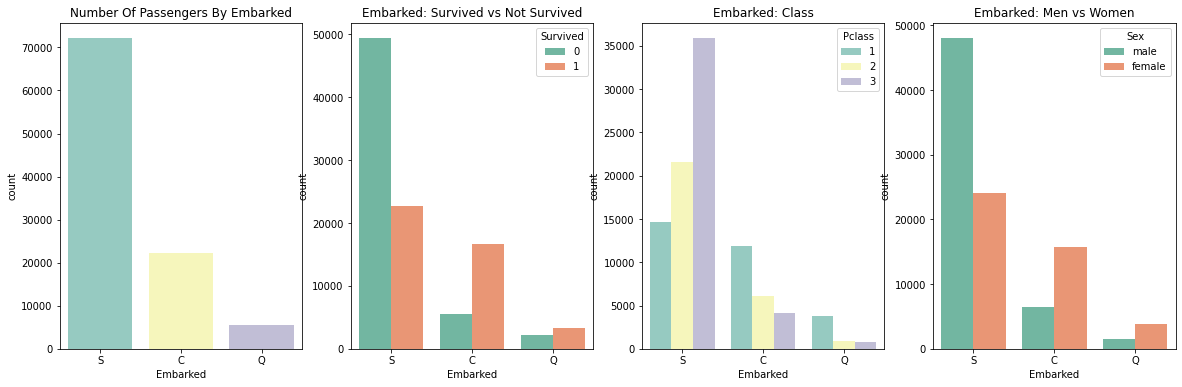

In [28]:
f,ax=plt.subplots(1,4,figsize=(20, 6))
sns.countplot(x="Embarked", data=data ,ax=ax[0], palette="Set3")
ax[0].set_title('Number Of Passengers By Embarked')

sns.countplot(x='Embarked',hue='Survived',data=data, ax=ax[1])
ax[1].set_title('Embarked: Survived vs Not Survived')

sns.countplot(x='Embarked',hue='Pclass',data=data, ax=ax[2], palette="Set3" )
ax[2].set_title('Embarked: Class')

sns.countplot(x='Embarked',hue='Sex',data=data, ax=ax[3], )
ax[3].set_title('Embarked: Men vs Women')

plt.show()

По признаку Embarked также наблюдается неравномерное распределение между значениями целевого признака. Для порта S соотношение выживших к не выжившим составило 0.32 к 0.69, в то время как для порта С - 0.75 к 0.25. Вероятно это обусловлено связанными признаками PClass и Sex. Так, в порт S направлялось 35895 пассажиров 3 класса, то есть 35.9% от всех пассажиров на борту, при этом 74.0% из них составляли мужчины. А по ранее полученным данным наименьший шанс выжить был у мужчин, путешествующих третьим классом.

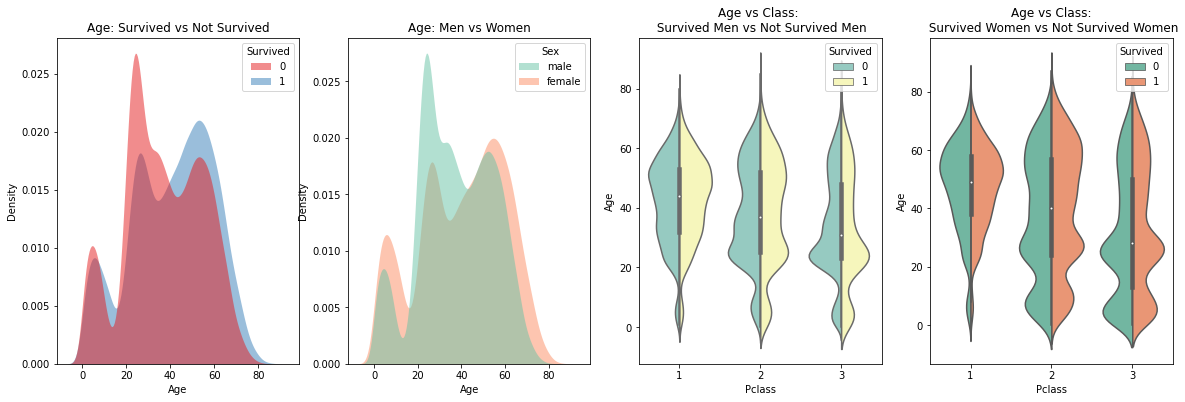

In [29]:
f,ax=plt.subplots(1,4,figsize=(20, 6))
sns.kdeplot(data=data, x="Age", hue="Survived",
   fill=True, common_norm=False, 
   alpha=.5, linewidth=0, ax=ax[0], palette="Set1")
ax[0].set_title('Age: Survived vs Not Survived')

sns.kdeplot(data=data, x="Age", hue="Sex",
   fill=True, common_norm=False, ax=ax[1], alpha=.5, linewidth=0) 
ax[1].set_title('Age: Men vs Women')

sns.violinplot(x="Pclass", y="Age", hue="Survived", 
            palette="Set3", data=data.loc[data.Sex=='male', :], split=True, ax=ax[2])
ax[2].set_title('Age vs Class: \n Survived Men vs Not Survived Men')

sns.violinplot(x="Pclass", y="Age", hue="Survived", 
            edgecolor=".6", data=data.loc[data.Sex=='female', :], split=True, ax=ax[3])
ax[3].set_title('Age vs Class:\n Survived Women vs Not Survived Women')
plt.show()


При анализе связи возраста и вероятности выживания видно, что наименьшая вероятность выжить была в диапазоне 25-38 лет (средняя и медиана около 36). Однако данное распределение сходно с распределением пассажиров по возрасту и полу, то есть в группе 25-38-летних пассажиров преобладали со значительным перевесом мужчины. При анализе графиков распределения по возрастам среди пассажиров разных классов заметно, что доля 25-38 летних выше в третьем классе, и наиболее низка в первом классе.

Изучим взаимосвязь цены билета и целевого признака.\
Для графиков будем использовать логарифмическое преобразование либо наблюдения, которые не превышают 90 перцентиль, так как исходное распределение признака Fare сильно скошено вправо, что не позволяет качественно визуализировать его без преобразований. 

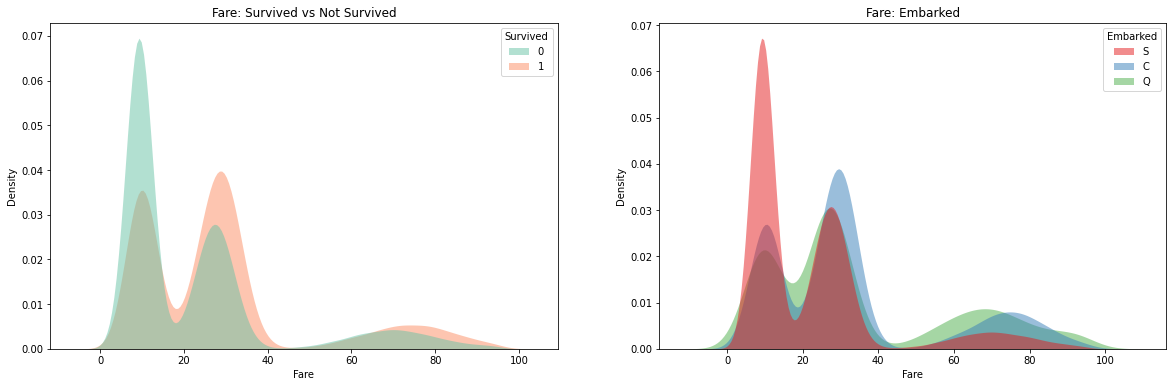

In [30]:
f,ax=plt.subplots(1,2,figsize=(20, 6))
sns.kdeplot(data=data.loc[data.Fare<data.Fare.quantile(0.90), :], x="Fare", hue="Survived",
   fill=True, common_norm=False, 
   alpha=.5, linewidth=0, ax=ax[0], palette="Set2")
ax[0].set_title('Fare: Survived vs Not Survived')

sns.kdeplot(data=data.loc[data.Fare<data.Fare.quantile(0.90), :], x="Fare", hue="Embarked",
   fill=True, common_norm=False, palette="Set1",
   alpha=.5, linewidth=0, ax=ax[1])
ax[1].set_title('Fare: Embarked')

plt.show()


In [31]:
data.groupby('Survived').Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,57153.0,32.647516,54.468198,0.68,9.16,13.05,29.72,732.01
1,42713.0,59.025192,83.393690,1.41,13.30,28.61,67.95,744.66


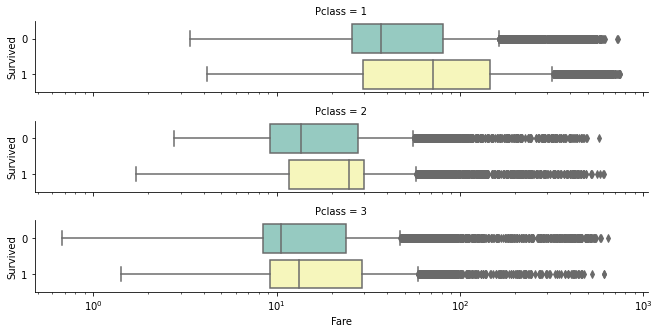

In [32]:

g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=6,  palette="Set3",
                data=data).set(xscale="log");

Наблюдается взаимосвязь между ценой билета и вероятностью выживания. Средняя цена билета среди выживших пассажиров составила 59.03 (медиана - 28.61), среди не выживших - 32.65 (медиана - 13.05). Показано, что в диапазоне цены ~5-11 вероятность выживания значительно ниже, при этом рост цены положительно связан с вероятностью выживания. Цена билета также связана с признаками Embarked и Pclass. Наибольшая цена показана для первого класса, вероятность выжить для пассажиров первого класса также выше. Есть взаимосвязь и цены с портом прибытия. Однако для утверждения о достоверности и характере связи необходимо проводить статистические тесты, что затрудняется формой распределения признака Fare.

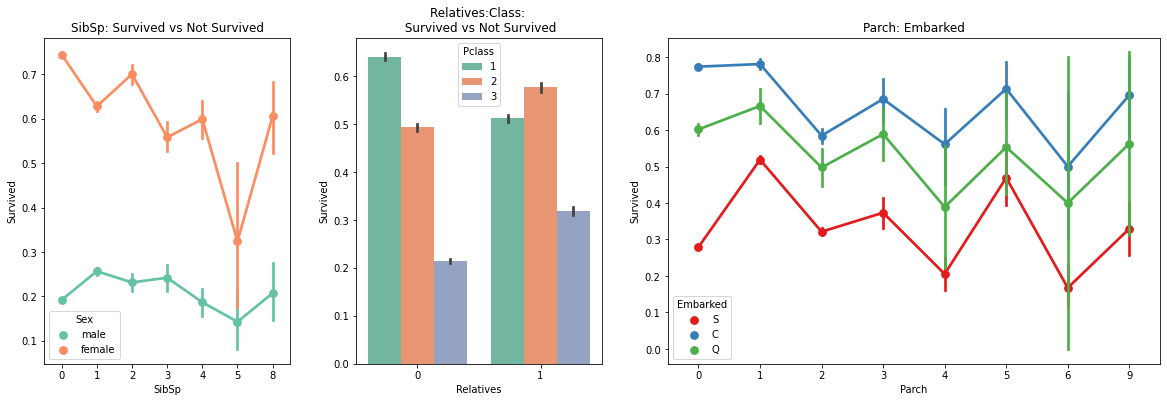

In [33]:
f,ax=plt.subplots(1,3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 2]})

sns.pointplot(x='SibSp', y='Survived',hue='Sex',data=data, ax=ax[0])
ax[0].set_title('SibSp: Survived vs Not Survived')

sns.barplot(x='Relatives',y='Survived', hue='Pclass',data=data, ax=ax[1], palette="Set2" )
ax[1].set_title('Relatives:Class: \n Survived vs Not Survived')

sns.pointplot(x='Parch',y='Survived', hue='Embarked',data=data, ax=ax[2], palette="Set1" )
ax[2].set_title('Parch: Embarked')

plt.show()

По признаку наличия родственников (SibSp, Parch, Relatives) связь с вероятностью выжить не так однозначна. В среднем процент выживших среди пассажиров без родственников (0 по всем признакам), составил 35.62%, а при наличии 1 и более родственника - 41.5%. Однако, при анализе данных признаков совместно с другими (например Sex, Pclass, Embarked), связь приобретает другие направления. Так, для представителей первого класса вероятность выжить была выше, при отсутствии родственников. Также, для женщин отсутствие братьев, сестер и супруга (0 по признаку SibSp) гарантировало более высокую вероятность выжить.\
Проанализируем взаимосвязь сконструированного признака Ticket_class и целевого признака Survived.

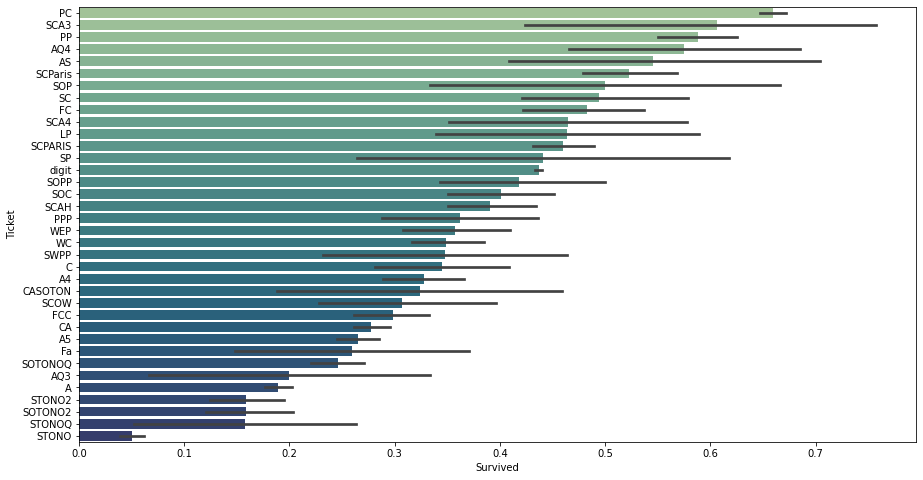

In [34]:
ord_ind = data.groupby(["Ticket_class"])['Survived'].mean().reset_index().sort_values('Survived', ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x='Survived', palette="crest",
            y="Ticket_class", data=data,
            order=ord_ind.Ticket_class)
plt.ylabel('Ticket');

Процент выживших варьирует в зависимости от типа билета (Ticket_class), однако доверительные интервалы для данных значений очень широки, поэтому сложно говорить о статистической значимости признака. Тем не менее, данный признак может быть полезен при построении предсказательных моделей.

# Summary

Проведен анализ данных о пассажирах Титаника, а также оценка возможности использования представленных в датасете признаков при построении предсказательных моделей по вероятности выживания пассажиров.
1. Исходный датасет содержит 12 признаков (два количественных и 10 качественных) и 100 000 записей.
2. Для анализа данных и построения моделей нецелесообразно использовать следующие признаки:
- PassengerId (идентификатор, все записи уникальны);
- Name (92.14% уникальных записей);
- Ticket (75.33% уникальных записей, однако может быть использован для конструирования других признаков);
- Cabin (67.9% наблюдений отсутствуют);
3. Проведена оценка распределений признаков. Для ряда признаков может понадобиться преобразование для использования в моделировании, например распределение признака Fare значимо скошено вправо. Так же необходимо удаление либо импутация пропущенных значений для признаков Age и Ticket. Исходные признаки могут быть использованы при конструировании новых признаков, в частности Age, Ticket, SibSp, Parch.
3. Все выделенные для дальнейшего анализа качественные признаки показали наличие связи с целевым признаком - Survived. 
5. Наиболее сильным прогностическим эффектом обладает признак Sex. Вне зависимости от других признаков процент выживших среди женщин был выше.
6. Наименьшая вероятность выжить установлена для мужчин ~25-38 лет, следовавших третьим классом в порт S и не имевших родственников. При этом данная категория представлена максимальным числом пассажиров среди сгруппированных по данным переменным наблюдений. 
    